<a href="https://colab.research.google.com/github/PutriAW/Predictions-of-Public-Response-to-Indonesian-Government-Policies/blob/main/Final_Project_DTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predictions of Public Response to Indonesian Government Policies**
Created By Group 6 Data Scientist 01 (DS01)
- Ghinaa Zain Nabiilah 
- Meidy Tataluckta 
- Putri Apriyanti Windya 
- Rizky Nur Alfian


# **Dataset**

---
 Dataset for this classification obtained from twitter and we do clean the data. data can be accessed using this following link : https://raw.githubusercontent.com/PutriAW/Predictions-of-Public-Response-to-Indonesian-Government-Policies/main/Dataset/raw%20dataset.csv
 

# **Description**

---
Background :
- 56% of Indonesians use Twitter
- Can be a means of conveying opinions
- Potential as a means of spreading hate speech that contains incitement to reject government policies through demonstrations that have the potential to harm many parties.

Goals / solutions:

It is necessary to develop a system that's able to build sentiment analysis of public opinion related to government policies that can be used by the government to considering new policies. In the end it can reduce possibility of demonstrations that have potential to harm many parties.

# **Problem to Solve**

---

Do sentiment Analysis to know whether a twitter tweet contain agree or disagree opinion to indonesian government policies

# **Data Preparation**

## **Data Exploration**

**Import All Libraries that Needed for Data Preparation**

In [ ]:
# install library for indonesian language stemming
!pip install Sastrawi

     |████████████████████████████████| 215kB 6.6MB/s 


In [ ]:
# Import Library
# text preprocessing
import pandas as pd
import numpy as np
import csv
import requests
import io
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re # regular expression
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # stemming indonesian language
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorization and splitting
from sklearn.feature_extraction.text import CountVectorizer # to create Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer # tfid Vector 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # confussion matrix
from sklearn.preprocessing import LabelEncoder # to convert classes to number 
from sklearn.model_selection import train_test_split  # for splitting data 
from sklearn.metrics import accuracy_score # to calculate accuracy
from mlxtend.plotting import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Get data from Github and import into dataframe
data = pd.read_csv("https://raw.githubusercontent.com/PutriAW/Predictions-of-Public-Response-to-Indonesian-Government-Policies/main/Dataset/raw%20dataset.csv")
data

,id_name,text,location,Label
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,NaN,Negatif
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif
...,...,...,...,...
3083,x76037954,@memefess Tuhan tidak membuat mahluk jika tida...,"Bandung, Indonesia",Positif
3084,x261157283,Itupun kalo efikasi dan efektivitasnya beneran...,"Diwek, Indonesia",Positif
3085,x1158584108106125312,vaksin corona adalah VAKSIN TERCEPAT YANG DITE...,NaN,Positif
3086,x1158584108106125312,"kata siapa ? KATA WHO, who sendiri bilang vaks...",NaN,Positif


In [ ]:
# Count Positif and Negatif label
data.Label.value_counts().to_frame()

,Label
Positif,1835
Negatif,1253


In [ ]:
data.isnull().sum()

id_name        0
text           0
location    1198
Label          0
dtype: int64

In [ ]:
data = data.fillna(method="ffill")
data.isnull().sum()

id_name     0
text        0
location    0
Label       0
dtype: int64

In [ ]:
data.head()

,id_name,text,location,Label
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,"DKI Jakarta, Indonesia",Negatif
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif


## **Text Cleaning**

**Case folding**

In [ ]:
def clean(data):
  temp_tweet = []

  for tw in data:
    # removal of @name[mention]
    tw = re.sub(r"(?:\@|https?\://)\S+", "", tw)

    # removal of links[https://blabala.com]
    # tw = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", tw)
    tw = re.sub(r"http\S+", "", tw)

    # removal of new line
    tw = re.sub('\n', '', tw)

    # removal of RT
    tw = re.sub('RT', '', tw)

    # removal of punctuations and numbers
    tw = re.sub("[^a-zA-Z^']", " ", tw)
    tw = re.sub(" {2,}", " ", tw)

    # remove leading and trailing whitespace
    tw = tw.strip()

    # remove whitespace with a single space
    tw = re.sub(r'\s+', ' ', tw)

    # convert text to Lowercase
    tw = tw.lower();
    temp_tweet.append(tw)
  return temp_tweet

In [ ]:
data['Clean_text'] = clean(data['text'])
data.head()

,id_name,text,location,Label,Clean_text
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif,disuntik vaksin emang sakit tapi kalo ga melal...
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif,ciptain lagu saja kakak maiayg judul nya di va...
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif,sjw anti vaksin mereka lebih percaya madu
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,"DKI Jakarta, Indonesia",Negatif,mak vaksin palsu sibuk sendiri kena prank u f ...
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif,ahli politik perlu diberi keutamaan vaksin cov...


**Tokenizing**

In [ ]:
def token(data):
  return data.apply(nltk.word_tokenize)

In [ ]:
data['Clean_text'] = token(data['Clean_text'])
data.head()

,id_name,text,location,Label,Clean_text
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif,"[disuntik, vaksin, emang, sakit, tapi, kalo, g..."
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif,"[ciptain, lagu, saja, kakak, maiayg, judul, ny..."
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif,"[sjw, anti, vaksin, mereka, lebih, percaya, madu]"
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,"DKI Jakarta, Indonesia",Negatif,"[mak, vaksin, palsu, sibuk, sendiri, kena, pra..."
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif,"[ahli, politik, perlu, diberi, keutamaan, vaks..."


**Stop Word Removal**

In [ ]:
def stop_words(data) :
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
data['Clean_text'] = stop_words(data['Clean_text'])
data.head()

,id_name,text,location,Label,Clean_text
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif,"[disuntik, vaksin, emang, sakit, kalo, ga, pro..."
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif,"[ciptain, lagu, kakak, maiayg, judul, nya, vak..."
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif,"[sjw, anti, vaksin, percaya, madu]"
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,"DKI Jakarta, Indonesia",Negatif,"[mak, vaksin, palsu, sibuk, kena, prank, u, f,..."
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif,"[ahli, politik, keutamaan, vaksin, covid, pakar]"


**Stemming**

In [ ]:
data['Clean_text'] = data['Clean_text'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
data.head()

,id_name,text,location,Label,Clean_text
0,x1242096848401129473,"disuntik vaksin emang sakit, tapi kalo ga mela...",Jakarta,Positif,disuntik vaksin emang sakit kalo ga proses sun...
1,x1217116132693311488,@MAIAsangJUARA Ciptain lagu saja kakak MAIA\n\...,Indonesia,Negatif,ciptain lagu kakak maiayg judul nya vaksin tid...
2,x79182387,@seeksixsuck SJW anti vaksin. Mereka lebih per...,"DKI Jakarta, Indonesia",Negatif,sjw anti vaksin percaya madu
3,x1095587722675159040,@LisaAmartatara3 Mak vaksin palsu Sibuk sendir...,"DKI Jakarta, Indonesia",Negatif,mak vaksin palsu sibuk kena prank u f u f u f
4,x62182882,@501Awani Ahli2 politik perlu diberi keutamaan...,Jakarta,Negatif,ahli politik keutamaan vaksin covid pakar


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem(data) :
    hasil = stemmer.stem(data)
    return hasil

In [ ]:
data['Clean_text'] = data.apply(lambda row : stem(row['Clean_text']), axis = 1)

**Slang Removal**

In [ ]:
slang_word = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt').text
dict_slang = eval(slang_word)

df_acronym = pd.read_csv('https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/acronym.txt', header=None, sep='=')
df_acronym.columns = ['Singkatan', 'kepanjangan']
df_acronym.kepanjangan = df_acronym.kepanjangan.apply(lambda x: x.strip().lower())
df_acronym.Singkatan = df_acronym.Singkatan.apply(lambda x: x.strip().lower())
dict_singkatan = pd.Series(df_acronym.kepanjangan.values,index=df_acronym.Singkatan).to_dict()

dict_clean = {**dict_singkatan, **dict_slang}

In [ ]:
def preprocessing_slang_singkatan(text, dict_clean=dict_clean):
  regex = r"\b(?:"+"|".join(re.escape(word) for word in dict_clean) + r")\b"
  reobj = re.compile(regex, re.I)
  
  return reobj.sub(lambda x:dict_clean[x.group(0)], text)

In [ ]:
def clean_all(x, dict_clean=dict_clean):
  x = preprocessing_slang_singkatan(x, dict_clean=dict_clean)
  return x

In [ ]:
tqdm.pandas()

In [ ]:
data['Clean_text'] = data.Clean_text.progress_apply(lambda x: clean_all(x, dict_clean=dict_clean))

100%|██████████| 3088/3088 [00:19<00:00, 156.20it/s]


In [ ]:
# Select Only Text Column
data1 = data[['Clean_text']]
data1

,Clean_text
0,suntik vaksin emang sakit kalau nggak proses s...
1,ciptain lagu kakak maiayg judul nya vaksin tid...
2,sjw anti vaksin percaya madu
3,ibu vaksin palsu sibuk kena prank kamu fahrenh...
4,ahli politik utama vaksin covid pakar
...,...
3083,tuhan mahluk guna bahan utama vaksin anti corona
3084,international telecommunication union kalau ef...
3085,vaksin corona vaksin cepat temu sejarah dunia ...
3086,world health organization world health organiz...


In [ ]:
# Select Only Label Column
data2 = data[['Label']]
data2

,Label
0,Positif
1,Negatif
2,Negatif
3,Negatif
4,Negatif
...,...
3083,Positif
3084,Positif
3085,Positif
3086,Positif


In [ ]:
dataset = pd.concat([data1, data2], axis=1)
dataset


,Clean_text,Label
0,suntik vaksin emang sakit kalau nggak proses s...,Positif
1,ciptain lagu kakak maiayg judul nya vaksin tid...,Negatif
2,sjw anti vaksin percaya madu,Negatif
3,ibu vaksin palsu sibuk kena prank kamu fahrenh...,Negatif
4,ahli politik utama vaksin covid pakar,Negatif
...,...,...
3083,tuhan mahluk guna bahan utama vaksin anti corona,Positif
3084,international telecommunication union kalau ef...,Positif
3085,vaksin corona vaksin cepat temu sejarah dunia ...,Positif
3086,world health organization world health organiz...,Positif


In [ ]:
# save data to csv
dataset.to_csv('Clean Dataset.csv', index=False)

In [ ]:
dataset = pd.read_csv('Clean Dataset.csv')
dataset

,Clean_text,Label
0,suntik vaksin emang sakit kalau nggak proses s...,Positif
1,ciptain lagu kakak maiayg judul nya vaksin tid...,Negatif
2,sjw anti vaksin percaya madu,Negatif
3,ibu vaksin palsu sibuk kena prank kamu fahrenh...,Negatif
4,ahli politik utama vaksin covid pakar,Negatif
...,...,...
3083,tuhan mahluk guna bahan utama vaksin anti corona,Positif
3084,international telecommunication union kalau ef...,Positif
3085,vaksin corona vaksin cepat temu sejarah dunia ...,Positif
3086,world health organization world health organiz...,Positif


**Data Visualization**

In [ ]:
#wordcloud
!pip install wordcloud

In [91]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
?WordCloud

In [92]:
cleanup_num = {"Label":{"Positif": 1, "Negatif": 0}}
dataset.replace(cleanup_num, inplace=True)

Gambaran pendapat masyarakat terkait kebijakan mengenai vaksin


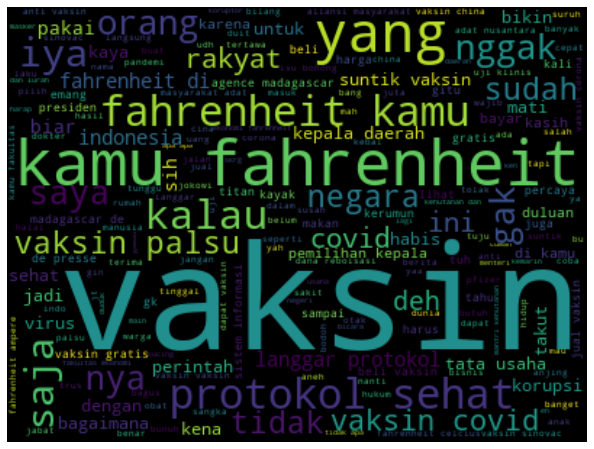

In [94]:
normal_words = ' '.join([word for word in dataset['Clean_text'][dataset['Label'] == 0]])
wordcloud = WordCloud(width = 400, height = 300, max_font_size = 100).generate(normal_words)
print('Gambaran pendapat masyarakat terkait kebijakan mengenai vaksin')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()

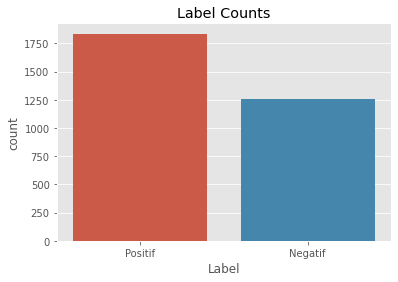

In [ ]:
#bar graph to count positive negative label
cleanup_num = {"Label":{1:"Positif", 0:"Negatif"}}
dataset.replace(cleanup_num, inplace=True)

fig2 = sns.countplot(x= 'Label',data = dataset)
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

## **Vectorization**

**Count Vectorizer**

In [ ]:
X = dataset['Clean_text']
# Count Vectorizer
count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(X)
count_vector.shape

(3088, 7080)

**TF-IDF Vectorizer**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfid_vector = tfidf_vectorizer.fit_transform(X)
tfid_vector.shape

(3088, 7080)

**Label Encoder**

In [ ]:
# Encode Target
encoder = LabelEncoder()
label = encoder.fit_transform(dataset['Label'])
label

array([1, 0, 0, ..., 1, 1, 1])

# **Data Splitting**

In [ ]:
sampler = SMOTE()
tfid_vector, label = sampler.fit_resample(tfid_vector, label)
X_train, X_test, y_train, y_test = train_test_split(tfid_vector, label , shuffle = True, test_size=0.20, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2936, 7080)
(734, 7080)
(2936,)
(734,)


# **Modelling**

## **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
# svmc = SVC(kernel='rbf',probability=True)
svmc = SVC(kernel='linear')

# Training SVM
svmc.fit(X_train, y_train)

# predict SVM to test data
y_pred_svm = svmc.predict(X_test)

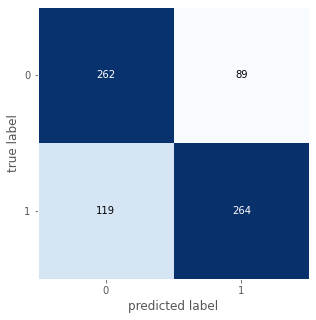

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm
plot_confusion_matrix(cm_svm, figsize=(5,5))
plt.show()

In [ ]:
# Classification report
print("Report : \n", classification_report(y_test, y_pred_svm))
print("Accuracy : ",accuracy_score(y_test,y_pred_svm))
accSVMC = accuracy_score(y_test,y_pred_svm)

Report : 
               precision    recall  f1-score   support

           0       0.69      0.75      0.72       351
           1       0.75      0.69      0.72       383

    accuracy                           0.72       734
   macro avg       0.72      0.72      0.72       734
weighted avg       0.72      0.72      0.72       734

Accuracy :  0.7166212534059946


## **MLP**

In [ ]:
from sklearn.neural_network import MLPClassifier

# mlpc = MLPClassifier(hidden_layer_sizes=(100, 4), max_iter=300, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1,
#                     learning_rate_init=.1)
mlpc = MLPClassifier(hidden_layer_sizes=(25,25,5), max_iter=500, alpha=0.03,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001,learning_rate_init=.1)

# Training knn
mlpc.fit(X_train, y_train)

# predict knn to test data
y_pred_mlpc = mlpc.predict(X_test)


Iteration 1, loss = 0.71993159
Iteration 2, loss = 0.70191574
Iteration 3, loss = 0.69987574
Iteration 4, loss = 0.69989984
Iteration 5, loss = 0.69989066
Iteration 6, loss = 0.69958168
Iteration 7, loss = 0.69972851
Iteration 8, loss = 0.69975479
Iteration 9, loss = 0.69968525
Iteration 10, loss = 0.69944958
Iteration 11, loss = 0.69965414
Iteration 12, loss = 0.69930424
Iteration 13, loss = 0.69924699
Iteration 14, loss = 0.69928147
Iteration 15, loss = 0.69923996
Iteration 16, loss = 0.69904752
Iteration 17, loss = 0.69885323
Iteration 18, loss = 0.69875563
Iteration 19, loss = 0.69840777
Iteration 20, loss = 0.69799025
Iteration 21, loss = 0.69737588
Iteration 22, loss = 0.69594539
Iteration 23, loss = 0.69406428
Iteration 24, loss = 0.69052807
Iteration 25, loss = 0.68234795
Iteration 26, loss = 0.66389684
Iteration 27, loss = 0.62303360
Iteration 28, loss = 0.71883574
Iteration 29, loss = 0.70170014
Iteration 30, loss = 0.70141277
Iteration 31, loss = 0.70064130
Iteration 32, los

In [ ]:
# Classification report
print("Report : \n", classification_report(y_test, y_pred_mlpc))
print("Accuracy : ",accuracy_score(y_test,y_pred_mlpc))
accMLPC = accuracy_score(y_test,y_pred_mlpc)

Report : 
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       351
           1       0.00      0.00      0.00       383

    accuracy                           0.48       734
   macro avg       0.24      0.50      0.32       734
weighted avg       0.23      0.48      0.31       734

Accuracy :  0.4782016348773842


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Neural Network**

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
!pip install keras

In [ ]:
# Import Libraries for Neural Network
from keras.models import Sequential
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Add model for Neural Network
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
          
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                70810     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 71,041
Trainable params: 71,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Run Model
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
294/294 [==============================] - 1s 4ms/step - loss: 0.6881 - accuracy: 0.5496 - val_loss: 0.6360 - val_accuracy: 0.6975
Epoch 2/10
294/294 [==============================] - 1s 3ms/step - loss: 0.5135 - accuracy: 0.8032 - val_loss: 0.5529 - val_accuracy: 0.7384
Epoch 3/10
294/294 [==============================] - 1s 3ms/step - loss: 0.2387 - accuracy: 0.9209 - val_loss: 0.6177 - val_accuracy: 0.7425
Epoch 4/10
294/294 [==============================] - 1s 3ms/step - loss: 0.1243 - accuracy: 0.9604 - val_loss: 0.6976 - val_accuracy: 0.7466
Epoch 5/10
294/294 [==============================] - 1s 3ms/step - loss: 0.0647 - accuracy: 0.9814 - val_loss: 0.7783 - val_accuracy: 0.7520
Epoch 6/10
294/294 [==============================] - 1s 3ms/step - loss: 0.0434 - accuracy: 0.9855 - val_loss: 0.8878 - val_accuracy: 0.7561
Epoch 7/10
294/294 [==============================] - 1s 3ms/step - loss: 0.0245 - accuracy: 0.9949 - val_loss: 0.9640 - val_accuracy: 0.7520
Epoch 

In [ ]:
# Check the Accuracy
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9959
Testing Accuracy:  0.7548


In [ ]:
# Plot accuracy
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

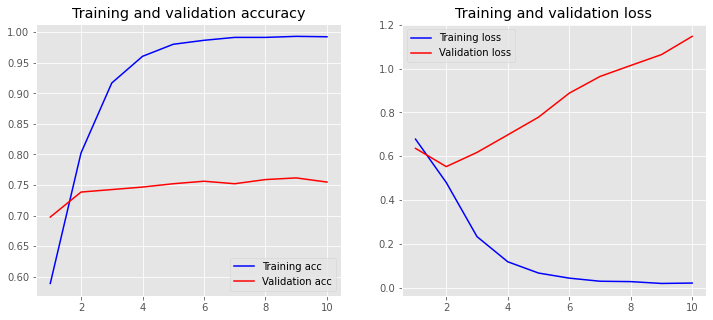

In [ ]:
plot_history(history)

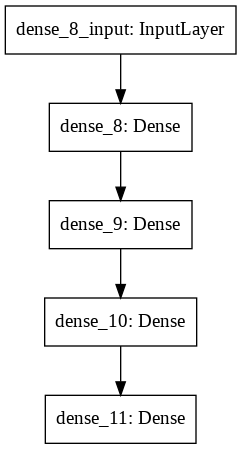

In [ ]:
# Save Model Layer
from tensorflow.keras.utils import plot_model
plot_model(model)

In [89]:
# Save Model
model.save('model', save_format="tf")

INFO:tensorflow:Assets written to: model/assets


## **Model Comparison**

In [ ]:
# Accuracy Comparison
models = ['SVM', 'MLP', 'NN']
accuracies = [accSVMC, accMLPC, accuracy]
comp = pd.DataFrame(list(zip(models, accuracies)), columns=['Model', 'Accuracy'])
comp

,Model,Accuracy
0,SVM,0.716621
1,MLP,0.478202
2,NN,0.754768


Conclusion : From 3 models above, Neural Network has the biggest accuracy.

# **Predict**

In [ ]:
#@title Input Kalimat
#@markdown Kalimat diawali dan diakhiri tanda kutip (" ")

kalimat="Auamat kesel bgt hari ini nonton tv isinya pilkada!!!  Stress bgt hampir setaun ini kuliah/sekolah online, eh pilkada ttp jalan tetap menaati protokol kesehatan Berak sekebon!!!! Cebok segayung"   #@param
#@markdown ---

In [ ]:
ls=[]
ls.append(kalimat)
df = pd.DataFrame(ls, columns=['text'])
df

,text
0,Auamat kesel bgt hari ini nonton tv isinya pil...


In [ ]:
df['text'] = clean(df['text'])
df

,text
0,auamat kesel bgt hari ini nonton tv isinya pil...


In [ ]:
df['text'] = token(df['text'])
df['text'] = stop_words(df['text'])
df

,text
0,"[auamat, kesel, bgt, nonton, tv, isinya, pilka..."


In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df.head()

,text
0,auamat kesel bgt nonton tv isinya pilkada stre...


In [ ]:
df['text'] = df.apply(lambda row : stem(row['text']), axis = 1)
df

,text
0,auamat kesel bgt nonton tv isi pilkada stress ...


In [ ]:
tqdm.pandas()

In [ ]:
df['text'] = df.text.progress_apply(lambda x: clean_all(x, dict_clean=dict_clean))
df

100%|██████████| 1/1 [00:00<00:00, 98.10it/s]


,text
0,auamat kesel banget nonton televisi ikatan sek...


In [ ]:
clean_sentence = tfidf_vectorizer.transform(df['text'])
clean_sentence.shape

(1, 7080)

In [ ]:
tst = model.predict(clean_sentence.toarray())
print("probability : ", float(tst))
# kel = model.predict_classes(clean_sentence.toarray())
label_pred = 'Setuju' if np.round(tst[0]) else 'Tidak Setuju'
print('predicted =',label_pred)

probability :  0.37454572319984436
predicted = Tidak Setuju
